## Preparataion

### Library

In [94]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Helper

In [95]:
def cek_null(df_data):
  nan_counts = df_data.isnull().sum()
  nan_proportions = (nan_counts / len(df_data)) * 100

  nan_info = pd.DataFrame({
      'NaN_Count': nan_counts,
      'NaN_Proportion': nan_proportions
  })

  return nan_info.sort_values(by='NaN_Count', ascending=False)

def count_unique_values(df_data):
  unique_counts = []
  for col in df_data.columns:
    unique_counts.append({'Column_Name': col, 'Unique_Value_Count': df_data[col].nunique()})
  return pd.DataFrame(unique_counts)

def heatmap_null(df,att_name):
  plt.figure(figsize=(10, 6))
  sns.heatmap(df[[att_name]].isnull(), cbar=False, cmap='viridis')
  plt.title(f'Heatmap of Null Values in {att_name}')
  plt.show()

def null_proportion(df, att_name):
    # Hitung proporsi null dan non-null berdasarkan loan_status
    null_by_loan_status = df.groupby('loan_status')[att_name].apply(lambda x: x.isnull().sum() / len(x) * 100)
    non_null_by_loan_status = df.groupby('loan_status')[att_name].apply(lambda x: x.notnull().sum() / len(x) * 100)

    # Gabungkan data untuk plotting
    plot_data = pd.DataFrame({
        'Null Proportion': null_by_loan_status,
        'Non-Null Proportion': non_null_by_loan_status
    })

    plot_data = plot_data.stack().reset_index()
    plot_data.columns = ['Loan Status', 'Type', 'Proportion']

    # Buat plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Loan Status', y='Proportion', hue='Type', data=plot_data)

    # Tambahkan label persentase di atas setiap batang
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

    plt.title(f'Proportion of Null and Non-Null Values in {att_name} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel('Proportion (%)')
    plt.ylim(0, 100)
    plt.legend(title='Value Type')
    plt.tight_layout()
    plt.show()

def hist_att(df,att_name):
  plt.figure(figsize=(12, 6))
  df[att_name].value_counts().sort_index().plot(kind='line')
  plt.title(f'Line Plot of {att_name} Distribution')
  plt.xlabel(att_name)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

def metrik(y_true, y_pred, y_prob):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_prob)
  return acc, prec, rec, f1, roc


### Parameter

In [97]:
threshold = 0.9

skor = 90

param_lgbm = {
    'objective': 'binary',
    'learning_rate': 0.01,\
    'importance_type': 'gain', # Sesuai kebutuhan seleksi fitur Anda
    'n_jobs': -1,             # Gunakan seluruh core CPU
    'random_state': 42,
    'verbosity': -1           # Menghilangkan pesan log yang tidak perlu
}

param_xgb = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'tree_method': 'hist',        # Wajib untuk data besar (>1 juta baris)
    'importance_type': 'gain',    # Konsistensi dengan metode seleksi fitur Anda
    'n_jobs': -1,
    'random_state': 42
}

### Load Dataset

In [152]:
df = pd.read_csv("data/loan.csv", low_memory=True)
df.shape

C:\Users\irfan.budianto\AppData\Local\Temp\ipykernel_23204\4066564547.py:1: DtypeWarning: Columns (0: desc, 1: next_pymnt_d, 2: verification_status_joint, 3: sec_app_earliest_cr_line, 4: hardship_type, 5: hardship_reason, 6: hardship_status, 7: hardship_start_date, 8: hardship_end_date, 9: payment_plan_start_date, 10: hardship_loan_status, 11: debt_settlement_flag_date, 12: settlement_status, 13: settlement_date) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/loan.csv", low_memory=True)


(2260668, 145)

## Pre Procession

### Feature Reduction

In [153]:
statuses = [
    'Fully Paid',
    'Charged Off',
]
df = df.loc[df['loan_status'].isin(statuses)].copy()

In [154]:
%%time
unique_value_df = count_unique_values(df)
columns_to_drop = unique_value_df.loc[unique_value_df['Unique_Value_Count'] <= 1]['Column_Name'].tolist()
df = df.drop(columns=columns_to_drop)

CPU times: total: 2.16 s
Wall time: 2.18 s


In [155]:
%%time
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
years_diff = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['issue_d_date'].dt.year)
months_diff = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['issue_d_date'].dt.month)
df['credit_duration'] = years_diff * 12 + months_diff
df['credit_duration'] = df['credit_duration'].astype(int)

df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
years_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['earliest_cr_line_date'].dt.year.fillna(0))
months_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['earliest_cr_line_date'].dt.month.fillna(0))
df['earliest_credit_duration'] = years_diff_earliest * 12 + months_diff_earliest
df['earliest_credit_duration'] = df['earliest_credit_duration'].astype(int)

att_drop = ['issue_d','issue_d_date','earliest_cr_line','earliest_cr_line_date']
df = df.drop(columns=att_drop)

CPU times: total: 266 ms
Wall time: 249 ms


In [156]:
%%time
nan_info = cek_null(df)
columns_to_drop_nan = nan_info[nan_info['NaN_Proportion'] > 50].index.tolist()
df = df.drop(columns=columns_to_drop_nan)

CPU times: total: 844 ms
Wall time: 840 ms


In [157]:
%%time
att_drop = ['emp_title', 'title', 'zip_code', 'addr_state']
df = df.drop(columns=att_drop, errors='ignore')

CPU times: total: 31.2 ms
Wall time: 25.2 ms


In [158]:
att_leakage = ['funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'grade', 'sub_grade', 
    'initial_list_status', 'total_pymnt', 'total_pymnt_inv', 
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 
    'hardship_flag', 'hardship_reason', 'hardship_status', 'hardship_amount', 
    'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 
    'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 
    'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 
    'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 
    'settlement_status', 'settlement_date', 'settlement_amount', 
    'settlement_percentage', 'settlement_term']
df = df.drop(columns=att_leakage, errors='ignore')

### Encoding

In [159]:
%%time
non_numeric_cols = df.select_dtypes(exclude=np.number).columns
print("Non-numeric columns:")
for col in non_numeric_cols:
    print(f"- {col}")

Non-numeric columns:
- term
- emp_length
- home_ownership
- verification_status
- loan_status
- purpose
- application_type
CPU times: total: 0 ns
Wall time: 4.4 ms


In [160]:
%%time
# Identifikasi kolom non-numerik selain target
non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'loan_status' in non_numeric_cols:
    non_numeric_cols.remove('loan_status')

# Label Encoding
le = LabelEncoder()
for col in non_numeric_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    df[col] = pd.to_numeric(df[col])

<timed exec>:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.


CPU times: total: 672 ms
Wall time: 675 ms


In [161]:
%%time
map = {
    'Fully Paid': 0,
    'Charged Off': 1
}
df['loan_status'] = df['loan_status'].map(map)
df['loan_status'] = pd.to_numeric(df['loan_status'])

CPU times: total: 31.2 ms
Wall time: 36.7 ms


### Correlation

In [162]:
%%time
# 1. Hitung matriks korelasi tanpa 'loan_status'
# numeric_only=True memastikan hanya kolom angka yang dihitung
corr_matrix = df.drop(columns=['loan_status'], errors='ignore').corr(numeric_only=True)

# 2. Ambil segitiga atas dari matriks untuk menghindari duplikat dan diagonal
# np.triu dengan k=1 akan mengecualikan diagonal utama (korelasi 1.0 dengan diri sendiri)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Ubah menjadi format DataFrame panjang (unpivot/stack)
high_corr_df = upper_tri.stack().reset_index()
high_corr_df.columns = ['Attribute_1', 'Attribute_2', 'Correlation']

# 4. Filter nilai korelasi >= 0.85 dan urutkan dari yang tertinggi
high_corr_df = high_corr_df[high_corr_df['Correlation'] >= threshold].sort_values(by='Correlation', ascending=False)

# Menampilkan hasil
high_corr_df

CPU times: total: 5.19 s
Wall time: 5.33 s


,Attribute_1,Attribute_2,Correlation
623,open_acc,num_sats,0.998717
2130,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.982017
1154,tot_cur_bal,tot_hi_cred_lim,0.973521
1681,mo_sin_old_rev_tl_op,earliest_credit_duration,0.907295


In [163]:
%%time

def iterative_feature_selection_optimized(X, y, threshold, sample_size=0.5):
    # 1. Penanganan Sampling (Mendukung 0 < sample_size <= 1)
    if sample_size < 1.0:
        print(f"Sampling {sample_size*100}% data untuk seleksi fitur...")
        X_s, _, y_s, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
    else:
        print("Menggunakan seluruh data (100%) untuk seleksi fitur...")
        X_s, y_s = X.copy(), y.copy()
    
    # 2. Hitung Gain sekali saja di awal
    print("Menghitung Initial Feature Importance (Gain)...")
    param = param_lgbm | {'is_unbalance': True}
    full_model = LGBMClassifier(**param)
    full_model.fit(X_s, y_s)
    initial_gains = pd.Series(full_model.feature_importances_, index=X_s.columns)
    
    # 3. Hitung Korelasi
    corr_matrix = X_s.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_pairs = []
    for col in upper.columns:
        for idx in upper.index:
            if upper.loc[idx, col] > threshold:
                high_corr_pairs.append((idx, col))
    
    dropped_features = set()
    print(f"Menganalisis {len(high_corr_pairs)} pasangan korelasi tinggi...\n")

    # 4. Seleksi Berdasarkan Gain
    for feat_a, feat_b in high_corr_pairs:
        if feat_a in dropped_features or feat_b in dropped_features:
            continue
            
        gain_a = initial_gains.get(feat_a, 0)
        gain_b = initial_gains.get(feat_b, 0)
        
        # Drop yang gain-nya lebih rendah
        final_drop = feat_a if gain_a < gain_b else feat_b
        dropped_features.add(final_drop)
        
        print(f"Pair: ({feat_a}, {feat_b}) | Gain: {feat_a}={gain_a:.2f}, {feat_b}={gain_b:.2f}")
        print(f" > Keputusan: Drop {final_drop}\n")

    final_list = list(dropped_features)
    return X.drop(columns=final_list), final_list

# Eksekusi
X = df.drop('loan_status', axis=1)
y = df['loan_status']
# Contoh penggunaan dengan sample_size 1.0 (Full Data)
X_final, dropped_list = iterative_feature_selection_optimized(X, y, threshold=0.9, sample_size=1.0)

Menggunakan seluruh data (100%) untuk seleksi fitur...
Menghitung Initial Feature Importance (Gain)...
Menganalisis 4 pasangan korelasi tinggi...

Pair: (num_actv_rev_tl, num_rev_tl_bal_gt_0) | Gain: num_actv_rev_tl=60194.51, num_rev_tl_bal_gt_0=2931.84
 > Keputusan: Drop num_rev_tl_bal_gt_0

Pair: (open_acc, num_sats) | Gain: open_acc=0.00, num_sats=0.00
 > Keputusan: Drop num_sats

Pair: (tot_cur_bal, tot_hi_cred_lim) | Gain: tot_cur_bal=0.00, tot_hi_cred_lim=835806.89
 > Keputusan: Drop tot_cur_bal

Pair: (mo_sin_old_rev_tl_op, earliest_credit_duration) | Gain: mo_sin_old_rev_tl_op=17726.26, earliest_credit_duration=0.00
 > Keputusan: Drop earliest_credit_duration

CPU times: total: 1min 59s
Wall time: 9.66 s


In [164]:
dropped_list

['num_rev_tl_bal_gt_0', 'earliest_credit_duration', 'num_sats', 'tot_cur_bal']

In [165]:
df = df.drop(columns=dropped_list)

In [166]:
df.shape

(1303607, 55)

In [167]:
cek_null(df).loc[cek_null(df)['NaN_Proportion'] > 0]

,NaN_Count,NaN_Proportion
mths_since_recent_inq,169549,13.006144
num_tl_120dpd_2m,115570,8.865402
mo_sin_old_il_acct,104295,8.000494
pct_tl_nvr_dlq,67681,5.191825
avg_cur_bal,67548,5.181623
num_rev_accts,67528,5.180089
mo_sin_rcnt_rev_tl_op,67528,5.180089
mo_sin_old_rev_tl_op,67528,5.180089
mo_sin_rcnt_tl,67527,5.180012
num_actv_rev_tl,67527,5.180012


In [168]:
df_null = cek_null(df)
att_null = df_null.loc[df_null['NaN_Proportion'] > 0].index.to_list()
df = df.dropna(subset=att_null)

In [169]:
df.shape

(1028993, 55)

## Split

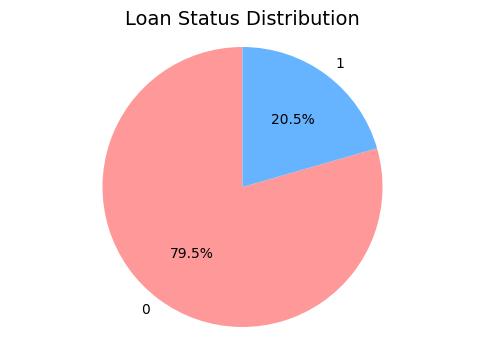

In [116]:
# Menghitung nilai
counts = df['loan_status'].value_counts()

# Membuat plot
plt.figure(figsize=(6, 4))
plt.pie(counts, 
        labels=counts.index, 
        autopct='%1.1f%%', # Menampilkan persentase dengan 1 desimal
        startangle=90,     # Memulai irisan pertama dari atas (jam 12)
        colors=['#ff9999','#66b3ff']) # Opsional: memberi warna spesifik

plt.title('Loan Status Distribution', fontsize=14)
plt.axis('equal') # Memastikan lingkaran benar-benar bulat
plt.show()

In [117]:
%%time

X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

CPU times: total: 3.56 s
Wall time: 2.46 s


## RFECV

In [148]:
%%time
# 0. Tentukan fraksi data (0.1 = 10%, 1.0 = 100%)
sample_frac = 1

# 1. Logika Pemilihan Data
if sample_frac < 1.0:
    X_proc = X_train_scaled.sample(frac=sample_frac, random_state=42)
    y_proc = y_train.loc[X_proc.index]
else:
    X_proc = X_train_scaled
    y_proc = y_train

# 2. Inisialisasi Model & CV
param = param_lgbm | {"is_unbalance": True}
model = LGBMClassifier(**param)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Konfigurasi RFECV
selector = RFECV(
    estimator=model,
    step=1, 
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Jalankan Seleksi pada data yang dipilih
selector.fit(X_proc, y_proc)

# 5. Hasil Fitur Terbaik
selected_features = X_train.columns[selector.support_].tolist()
print(f"Menggunakan {sample_frac*100}% data")
print(f"Jumlah fitur optimal: {selector.n_features_}")
print(f"Fitur terpilih: {selected_features}")

Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 fe

Varians PC1: 0.2695 (26.95%)
Varians PC2: 0.1819 (18.19%)
Total Informasi yang Terjaga: 0.4514 (45.14%)


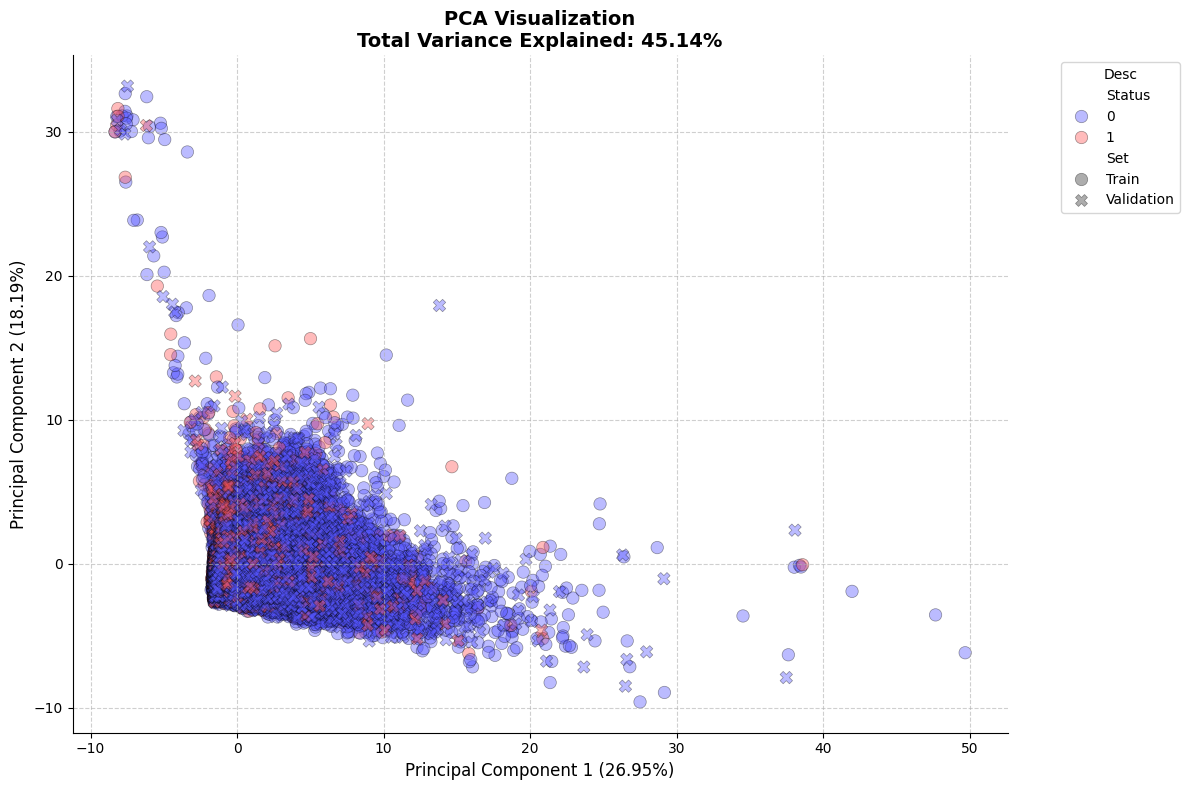

CPU times: total: 12.5 s
Wall time: 12.5 s


In [126]:
%%time
# 1. Inisialisasi PCA untuk 2 Komponen Utama
pca = PCA(n_components=2)

# 2. Fit pada data training dan transformasi
# Kita gunakan .values karena PCA dari sklearn bekerja optimal dengan numpy array
att = ['term','dti','credit_duration','bc_open_to_buy','avg_cur_bal','acc_open_past_24mths','tot_hi_cred_lim']
X_train_pca = pca.fit_transform(X_train_scaled[att].values)
X_val_pca = pca.transform(X_val_scaled[att].values)

# 3. Cek Explained Variance Ratio (Penting untuk analisis tesis)
varians_pc1 = pca.explained_variance_ratio_[0]
varians_pc2 = pca.explained_variance_ratio_[1]
total_varians = varians_pc1 + varians_pc2

print(f"Varians PC1: {varians_pc1:.4f} ({varians_pc1*100:.2f}%)")
print(f"Varians PC2: {varians_pc2:.4f} ({varians_pc2*100:.2f}%)")
print(f"Total Informasi yang Terjaga: {total_varians:.4f} ({total_varians*100:.2f}%)")

# 4. Membuat DataFrame hasil PCA untuk memudahkan plotting
# Kita gabungkan hasil PCA dengan label asli (y_train dan y_val)
df_pca_train = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_pca_train['Status'] = y_train.values
df_pca_train['Set'] = 'Train'

df_pca_val = pd.DataFrame(X_val_pca, columns=['PC1', 'PC2'])
df_pca_val['Status'] = y_val.values
df_pca_val['Set'] = 'Validation'

# Gabungkan untuk plotting sekaligus (opsional, tapi bagus untuk melihat distribusi gabungan)
df_pca_combined = pd.concat([df_pca_train, df_pca_val], ignore_index=True)

# 5. Visualisasi
plt.figure(figsize=(12, 8))

# Gunakan seaborn scatterplot untuk visualisasi yang lebih cantik
# hue='Status' akan otomatis memberi warna berbeda berdasarkan kelas (Gagal Bayar vs Lunas)
sns.scatterplot(
    data=df_pca_combined,
    x='PC1', 
    y='PC2', 
    hue='Status', 
    style='Set',       # Membedakan Train (lingkaran) dan Val (segitiga/kotak)
    palette='seismic', # Palet warna merah-biru yang umum untuk klasifikasi biner
    alpha=0.4,
    s=80,              # Ukuran titik
    edgecolor='k',     # Garis tepi hitam tipis agar titik terlihat jelas
    linewidth=0.5
)

plt.title(f'PCA Visualization\nTotal Variance Explained: {total_varians*100:.2f}%', fontsize=14, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({varians_pc1*100:.2f}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({varians_pc2*100:.2f}%)', fontsize=12)
plt.legend(title='Desc', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Hilangkan border atas dan kanan agar lebih bersih (gaya jurnal)
sns.despine()

plt.tight_layout()
plt.show()

In [149]:
# 1. Ambil skor pentingnya fitur dari model internal RFECV
importances = selector.estimator_.feature_importances_

# 2. Pasangkan dengan nama fitur yang terpilih
feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Importance_Score': importances
}).sort_values(by='Importance_Score', ascending=False)

feature_scores.head(10)

,Feature,Importance_Score
1,term,1.208044e+06
21,tot_hi_cred_lim,2.948353e+05
12,bc_open_to_buy,2.718879e+05
23,credit_duration,2.583744e+05
6,dti,2.574687e+05
10,acc_open_past_24mths,2.140216e+05
5,verification_status,1.498740e+05
11,avg_cur_bal,1.031921e+05
14,mort_acc,9.147230e+04
3,home_ownership,7.943457e+04


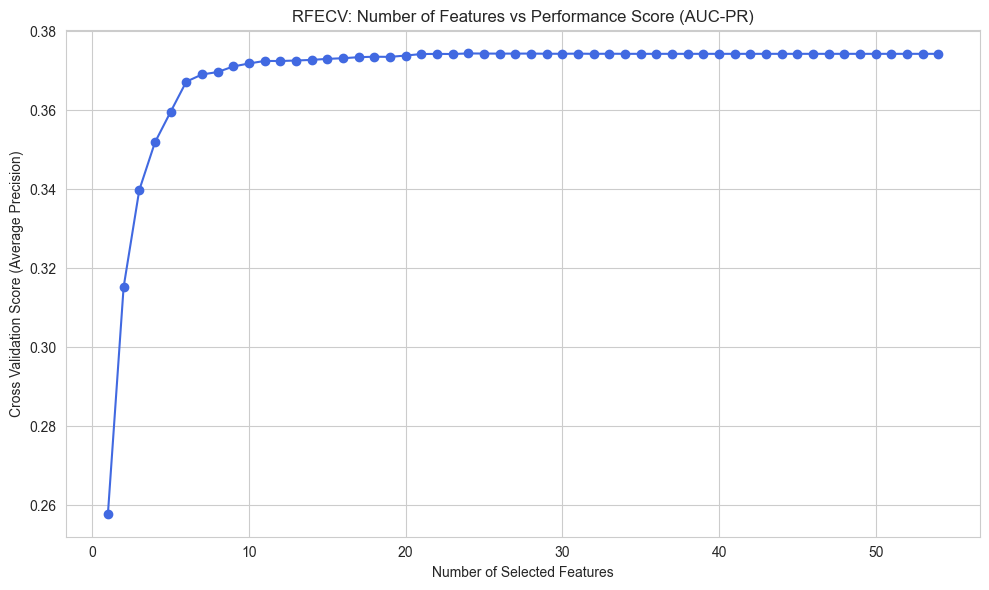

In [150]:
# Plotting hasil RFECV
plt.figure(figsize=(10, 6))
plt.title('RFECV: Number of Features vs Performance Score (AUC-PR)')
plt.xlabel('Number of Selected Features')
plt.ylabel('Cross Validation Score (Average Precision)')

# Mengambil skor dari selector
# Range x dimulai dari 1 hingga jumlah total fitur awal
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), 
         selector.cv_results_['mean_test_score'], 
         marker='o', color='royalblue')

plt.grid(True)
plt.tight_layout()
plt.savefig('rfecv_performance_plot.png')

Jumlah Fitur Optimal (Titik Siku): 6


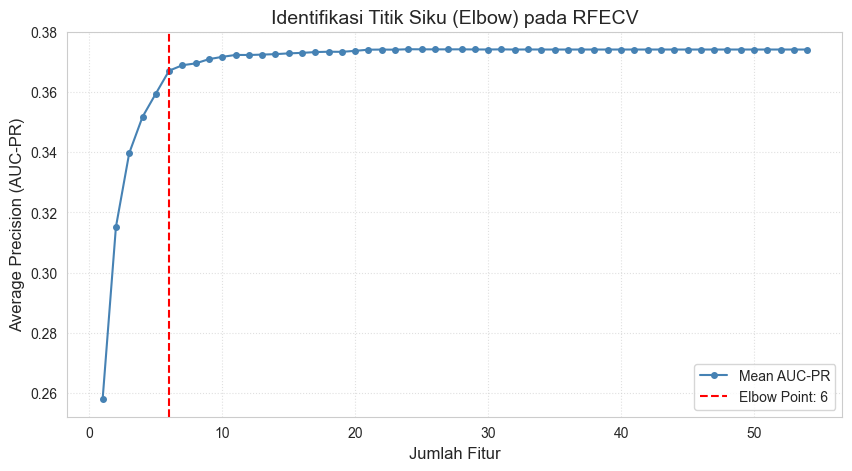

In [151]:
from kneed import KneeLocator
# import matplotlib.pyplot as plt

# 1. Ekstrak skor rata-rata dari hasil RFECV
# cv_results_['mean_test_score'] menyimpan performa tiap jumlah fitur
scores = selector.cv_results_['mean_test_score']
num_features = range(1, len(scores) + 1)

# 2. Gunakan KneeLocator untuk mencari titik di mana grafik mulai melandai
# Curve 'concave' dan direction 'increasing' cocok untuk kurva akurasi/AUC-PR
kn = KneeLocator(num_features, scores, curve='concave', direction='increasing')
elbow_point = kn.knee

print(f"Jumlah Fitur Optimal (Titik Siku): {elbow_point}")

# 3. Visualisasi untuk validasi
plt.figure(figsize=(10, 5))
plt.plot(num_features, scores, color='steelblue', marker='o', markersize=4, label='Mean AUC-PR')
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point: {elbow_point}')

plt.title('Identifikasi Titik Siku (Elbow) pada RFECV', fontsize=14)
plt.xlabel('Jumlah Fitur', fontsize=12)
plt.ylabel('Average Precision (AUC-PR)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Modelling

### Scenario A

#### LightGBM

In [127]:
%%time
# 1. Filter Fitur Hasil RFECV
# Memastikan model hanya menggunakan fitur paling optimal
X_train_a = X_train_scaled[att]
X_val_a = X_val_scaled[att]

# 2. Inisialisasi Model LightGBM Skenario A
# is_unbalance=True: Model memberikan bobot lebih pada kelas minoritas secara otomatis
param = param_lgbm | {"is_unbalance":True}
model_lgbm_a = LGBMClassifier(**param)

# 3. Pelaksanaan Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['f1', 'average_precision', 'roc_auc']

print("Menjalankan Cross-Validation (5-Fold)...")
cv_results = cross_validate(
    model_lgbm_a, 
    X_train_a, 
    y_train, 
    cv=skf, 
    scoring=scoring_metrics, 
    n_jobs=-1
)

# 4. Pelatihan pada Seluruh Data Training
model_lgbm_a.fit(X_train_a, y_train)

# 5. Pengujian pada Data Validasi
y_pred = model_lgbm_a.predict(X_val_a)
y_proba = model_lgbm_a.predict_proba(X_val_a)[:, 1]

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO A")
print("="*30)

# Rata-rata Skor Cross Validation
print(f"CV F1-Score         : {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results['test_roc_auc'].mean():.4f}")

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred))

auc_pr = average_precision_score(y_val, y_proba)
print(f"Final AUC-PR on Validation: {auc_pr:.4f}")

Menjalankan Cross-Validation (5-Fold)...

HASIL EVALUASI SKENARIO A
CV F1-Score         : 0.2962 (+/- 0.0022)
CV AUC-PR (Avg Prec): 0.3642
CV ROC-AUC          : 0.6884

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.82      0.93      0.87    163534
           1       0.44      0.22      0.29     42265

    accuracy                           0.78    205799
   macro avg       0.63      0.57      0.58    205799
weighted avg       0.74      0.78      0.75    205799

Final AUC-PR on Validation: 0.3631
CPU times: total: 29.3 s
Wall time: 7.4 s


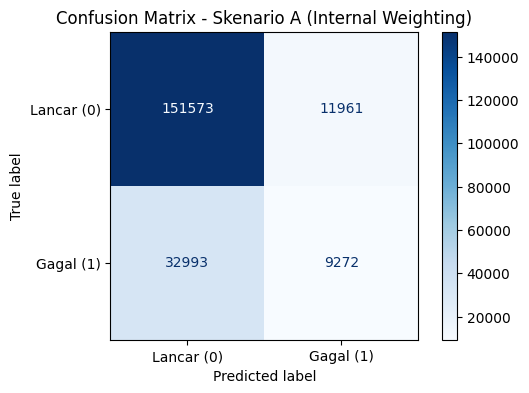

TP: 9272 FN: 32993 FP: 11961 TN: 151573


In [128]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)','Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Skenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

#### XGBoost

In [129]:
%%time
# 1. Filter Fitur Hasil RFECV
X_train_xgb = X_train_scaled[att]
X_val_xgb = X_val_scaled[att]

# 2. Hitung Rasio untuk Penanganan Imbalance
# Formula: sum(negative) / sum(positive)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# 3. Inisialisasi Model XGBoost
param = param_xgb | {"scale_pos_weight":ratio}
model_xgb_a = XGBClassifier(**param)

# 4. Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['f1', 'average_precision', 'roc_auc']

print("Menjalankan Cross-Validation XGBoost (5-Fold)...")
cv_results_xgb = cross_validate(
    model_xgb_a, 
    X_train_xgb, 
    y_train, 
    cv=skf, 
    scoring=scoring_metrics, 
    n_jobs=-1
)

# 5. Training dan Prediksi
model_xgb_a.fit(X_train_xgb, y_train)
y_pred_xgb = model_xgb_a.predict(X_val_xgb)
y_proba_xgb = model_xgb_a.predict_proba(X_val_xgb)[:, 1]

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO A: XGBOOST")
print("="*30)

print(f"CV F1-Score         : {cv_results_xgb['test_f1'].mean():.4f} (+/- {cv_results_xgb['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results_xgb['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results_xgb['test_roc_auc'].mean():.4f}")

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred_xgb))

auc_pr_xgb = average_precision_score(y_val, y_proba_xgb)
print(f"Final AUC-PR on Validation: {auc_pr_xgb:.4f}")

Menjalankan Cross-Validation XGBoost (5-Fold)...

HASIL EVALUASI SKENARIO A: XGBOOST
CV F1-Score         : 0.4182 (+/- 0.0015)
CV AUC-PR (Avg Prec): 0.3660
CV ROC-AUC          : 0.6888

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.87      0.65      0.75    163534
           1       0.32      0.62      0.42     42265

    accuracy                           0.65    205799
   macro avg       0.59      0.64      0.58    205799
weighted avg       0.76      0.65      0.68    205799

Final AUC-PR on Validation: 0.3653
CPU times: total: 29.5 s
Wall time: 8.93 s


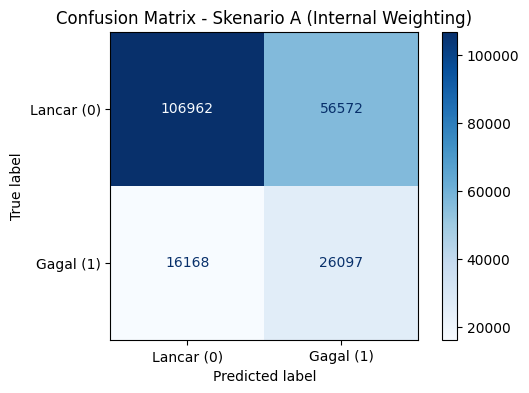

TP: 26097 FN: 16168 FP: 56572 TN: 106962


In [130]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred_xgb)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)', 'Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Skenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

### Scenario B

#### LightGBM

In [131]:
%%time
# 1. Persiapan Data (Hanya menggunakan fitur terpilih dari RFECV)
X_train_b = X_train_scaled[att]
X_val_b = X_val_scaled[att]

# 2. Konfigurasi ADASYN (Optimasi CPU)
nn_params = NearestNeighbors(n_neighbors=5, n_jobs=-1)
adasyn = ADASYN(random_state=42, n_neighbors=nn_params, sampling_strategy='auto')

param = param_lgbm | {"is_unbalance":False}

# 3. Pemodelan LightGBM (is_unbalance dimatikan)
model_lgbm_b = LGBMClassifier(**param)

# 4. Cross-Validation dengan Pipeline (Menghindari Data Leakage)
# Pipeline memastikan ADASYN hanya berjalan di data training setiap fold
pipeline_lgbm = ImbPipeline([
    ('resample', adasyn),
    ('classifier', model_lgbm_b)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Menjalankan Cross-Validation Skenario B (LGBM + ADASYN)...")
cv_results_b = cross_validate(
    pipeline_lgbm, 
    X_train_b, y_train, 
    cv=skf, 
    scoring=['f1', 'average_precision', 'roc_auc'],
    n_jobs=-1 
)

# 5. Final Resampling & Training untuk Prediksi Validasi
print("Melakukan Final Resampling pada seluruh data Train...")
X_train_res, y_train_res = adasyn.fit_resample(X_train_b, y_train)

print("Training model final Skenario B...")
model_lgbm_b.fit(X_train_res, y_train_res)

# 6. Pengujian
y_pred_b = model_lgbm_b.predict(X_val_b)
y_proba_b = model_lgbm_b.predict_proba(X_val_b)[:, 1]

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO B: LGBM + ADASYN")
print("="*30)
print(f"CV F1-Score         : {cv_results_b['test_f1'].mean():.4f} (+/- {cv_results_b['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results_b['test_average_precision'].mean():.4f}")
print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred_b))

Menjalankan Cross-Validation Skenario B (LGBM + ADASYN)...
Melakukan Final Resampling pada seluruh data Train...
Training model final Skenario B...

HASIL EVALUASI SKENARIO B: LGBM + ADASYN
CV F1-Score         : 0.4136 (+/- 0.0013)
CV AUC-PR (Avg Prec): 0.3571

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.87      0.63      0.73    163534
           1       0.31      0.63      0.41     42265

    accuracy                           0.63    205799
   macro avg       0.59      0.63      0.57    205799
weighted avg       0.75      0.63      0.67    205799

CPU times: total: 5min 35s
Wall time: 37 s


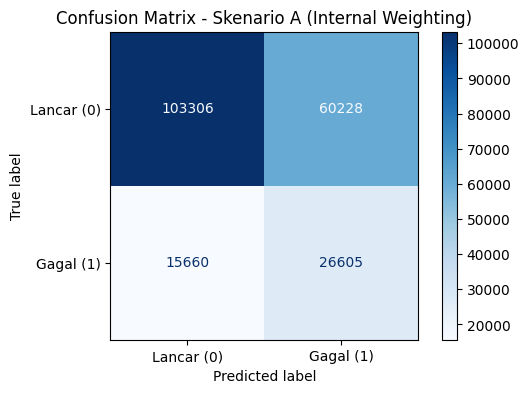

TP: 26605 FN: 15660 FP: 60228 TN: 103306


In [132]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred_b)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)', 'Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Skenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

#### XGBoost

In [133]:
%%time
# 1. Inisialisasi Model XGBoost Skenario B
# scale_pos_weight=1: Karena data sudah diseimbangkan secara fisik oleh ADASYN
param = param_xgb | {"scale_pos_weight":1}
model_xgb_b = XGBClassifier(**param)

# 2. Pelatihan Model pada Data ADASYN
print("Training XGBoost pada data hasil resampling ADASYN...")
model_xgb_b.fit(X_train_res, y_train_res)

# 3. Prediksi pada Data Validasi
y_pred_xgb_b = model_xgb_b.predict(X_val_b)
y_proba_xgb_b = model_xgb_b.predict_proba(X_val_b)[:, 1]

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO B: XGBOOST + ADASYN")
print("="*30)

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred_xgb_b))

auc_pr_xgb_b = average_precision_score(y_val, y_proba_xgb_b)
print(f"Final AUC-PR on Validation: {auc_pr_xgb_b:.4f}")

Training XGBoost pada data hasil resampling ADASYN...

HASIL EVALUASI SKENARIO B: XGBOOST + ADASYN

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.87      0.62      0.73    163534
           1       0.31      0.65      0.42     42265

    accuracy                           0.63    205799
   macro avg       0.59      0.63      0.57    205799
weighted avg       0.76      0.63      0.66    205799

Final AUC-PR on Validation: 0.3616
CPU times: total: 41.8 s
Wall time: 1.5 s


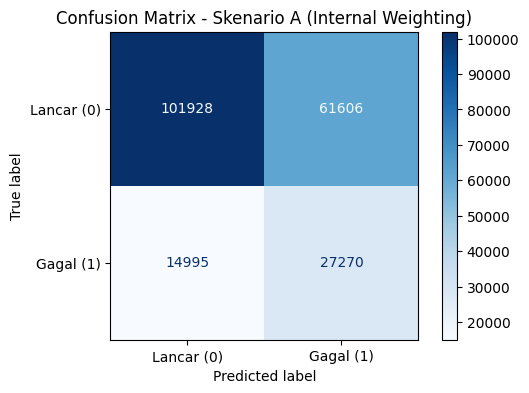

TP: 27270 FN: 14995 FP: 61606 TN: 101928


In [134]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred_xgb_b)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)', 'Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Skenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

## Analysis

### PCA

In [139]:
X_resampled, y_resampled = adasyn.fit_resample(X_train_scaled, y_train)

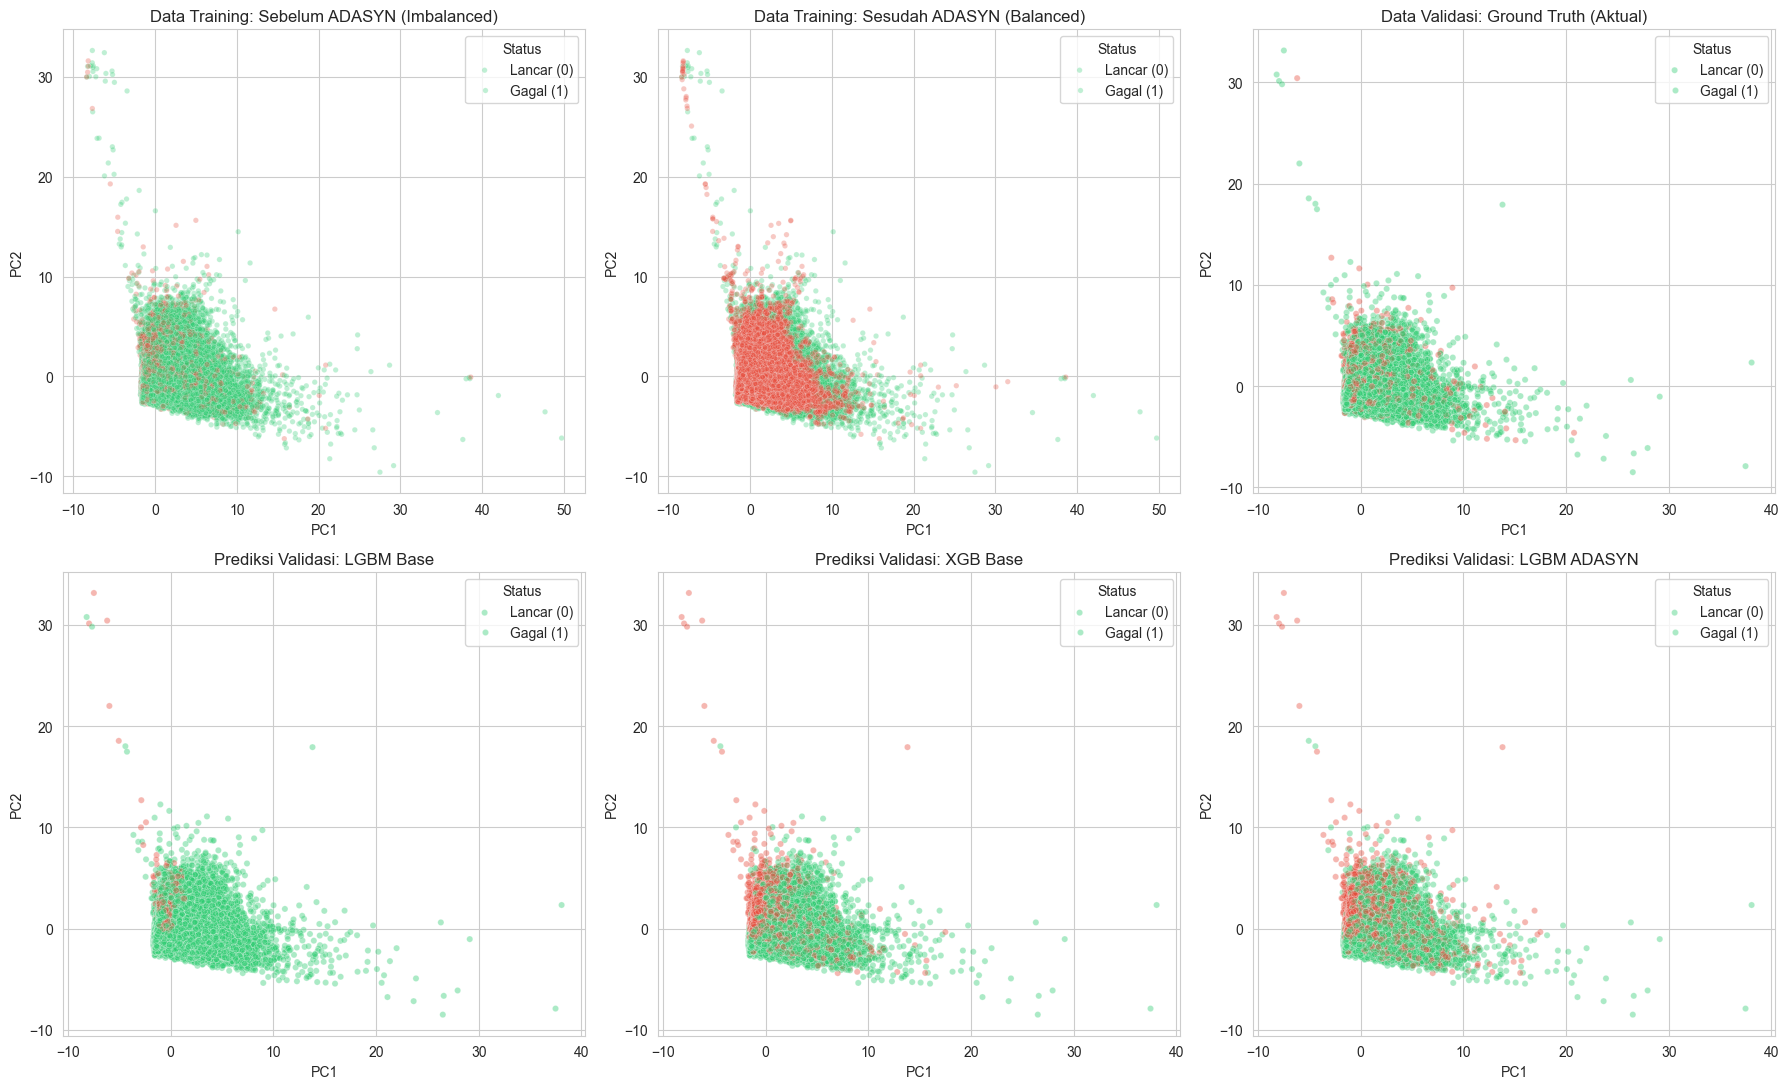

In [147]:
def plot_comprehensive_pca(X_orig, y_orig, X_res, y_res, X_val, y_val, models_dict):
    """
    X_orig, y_orig: Data training sebelum ADASYN
    X_res, y_res  : Data training sesudah ADASYN
    X_val, y_val  : Data validasi (asli)
    models_dict   : {'LGBM Base': lgbm_base, 'XGB Base': xgb_base, 
                     'LGBM ADASYN': lgbm_adasyn, 'XGB ADASYN': xgb_adasyn}
    """
    # 1. Inisialisasi PCA (Fit pada data original agar koordinat konsisten)
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X_orig)
    
    # Transformasi semua dataset
    pca_orig = pca.transform(X_orig)
    pca_res = pca.transform(X_res)
    pca_val = pca.transform(X_val)
    
    # 2. Setup Plot Grid (2 Baris: Distribusi Data & Prediksi Model)
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    palette = {0: '#2ecc71', 1: '#e74c3c'} # Hijau: Lancar, Merah: Gagal
    
    # --- BARIS 1: DISTRIBUSI DATA TRAINING ---
    # Sebelum ADASYN
    sns.scatterplot(x=pca_orig[:, 0], y=pca_orig[:, 1], hue=y_orig, 
                    ax=axes[0, 0], palette=palette, alpha=0.3, s=15)
    axes[0, 0].set_title("Data Training: Sebelum ADASYN (Imbalanced)", fontsize=12)
    
    # Sesudah ADASYN
    sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 1], hue=y_res, 
                    ax=axes[0, 1], palette=palette, alpha=0.3, s=15)
    axes[0, 1].set_title("Data Training: Sesudah ADASYN (Balanced)", fontsize=12)
    
    # Ground Truth Validasi
    sns.scatterplot(x=pca_val[:, 0], y=pca_val[:, 1], hue=y_val, 
                    ax=axes[0, 2], palette=palette, alpha=0.4, s=20)
    axes[0, 2].set_title("Data Validasi: Ground Truth (Aktual)", fontsize=12)

    # --- BARIS 2: PREDIKSI MODEL PADA DATA VALIDASI ---
    # Ambil 3 model utama untuk dibandingkan (Contoh: LGBM Base vs LGBM ADASYN vs XGB ADASYN)
    model_names = list(models_dict.keys())[:3] 
    
    for i, name in enumerate(model_names):
        y_pred = models_dict[name].predict(X_val)
        sns.scatterplot(x=pca_val[:, 0], y=pca_val[:, 1], hue=y_pred, 
                        ax=axes[1, i], palette=palette, alpha=0.4, s=20)
        axes[1, i].set_title(f"Prediksi Validasi: {name}", fontsize=12)

    for ax in axes.flat:
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.legend(title="Status", labels=["Lancar (0)", "Gagal (1)"])

    plt.tight_layout()
    plt.show()

# CARA PENGGUNAAN:
# Pastikan X_resampled dan y_resampled sudah dibuat dengan ADASYN
models = {'LGBM Base': model_lgbm_a, 'XGB Base': model_xgb_a, 'LGBM ADASYN': model_lgbm_b, 'XGB ADASYN': model_xgb_b}
plot_comprehensive_pca(X_train_scaled[att], y_train, X_resampled[att], y_resampled, X_val_scaled[att], y_val, models)